# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

# read the dataset

In [2]:
df = pd.read_excel('review-details.xlsx', engine = 'openpyxl', usecols= ['review_title', 'review_text', 'review_rating'])

In [3]:
df.head()

,review_rating,review_title,review_text
0,5,Dove Men’s + Deodorant,"As you get older, you know what you like and w..."
1,5,Great for a marmite lover!,Three gigantic marmite jars that will last pro...
2,4,Vitamin B12.,Excellent
3,5,A Very Handy Flavour Top - Up to Keep In The C...,A great flavour top - up for slow cooking.
4,5,Very handy,Does what is says it does


# EDA and preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_rating  2501 non-null   int64 
 1   review_title   2403 non-null   object
 2   review_text    2501 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.7+ KB


5    1848
4     319
1     146
3     107
2      81
Name: review_rating, dtype: int64


<AxesSubplot:>

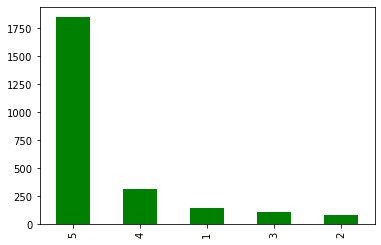

In [5]:
print(df['review_rating'].value_counts())
df['review_rating'].value_counts().plot.bar(color='green')

In [6]:
df.isnull().sum()

review_rating     0
review_title     98
review_text       0
dtype: int64

In [7]:
df = df.dropna()

# Now Separate a Dependent and Independent Features

In [8]:
# Dependent Features
y = df['review_rating']

# Independent Features
x = df.drop('review_rating', axis=1)

In [9]:
messages = x.copy()
messages = messages.reset_index()   ## we reset the index because above we drop the nan values because of this the index will be disturb

# Stemming The Words
Simpy we change the words into its root word

In [10]:
stopwords = set(stopwords.words('english'))

In [11]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['review_text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [12]:
corpus[0]

'get older know like suitabl bodi like dove product give fresh wide awak feel dandruff flakey skin smelli pit'

# now let tokenize our dataset

In [13]:
voc_size = 15000
max_length = 120
embedding_dim = 16

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=voc_size, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)


Here, the value of oov_token is set to be ‘OOV’. That means any unknown words will be replaced by oov_token.

In [14]:
sequences = tokenizer.texts_to_sequences(corpus)

embedded_docs = pad_sequences(sequences, maxlen=max_length, padding='post', truncating= 'post')

In [15]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [16]:
X_final.shape, y_final.shape

((2403, 120), (2403,))

# splitting the data intotrain and test

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

# SVM

In [18]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  2,   0,   0,   1,  31],
       [  0,   0,   0,   0,  20],
       [  1,   1,   2,   3,  31],
       [  8,   1,   1,   8,  79],
       [  9,   6,   8,  17, 492]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

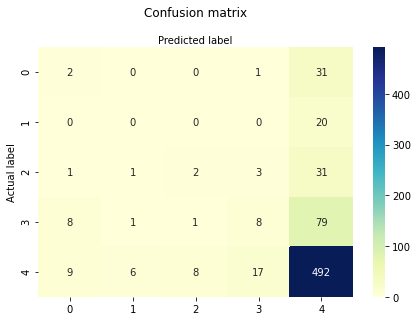

In [21]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#Text(0.5,257.44,'Predicted label');

In [23]:
from sklearn.metrics import classification_report
#target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.10      0.06      0.07        34
           2       0.00      0.00      0.00        20
           3       0.18      0.05      0.08        38
           4       0.28      0.08      0.13        97
           5       0.75      0.92      0.83       532

    accuracy                           0.70       721
   macro avg       0.26      0.22      0.22       721
weighted avg       0.61      0.70      0.64       721



# Naives bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

# Predict Output
predicted = model.predict([X_test[6]])

print("Actual Value:", y_test[6])
print("Predicted Value:", predicted[0])

Actual Value: 4
Predicted Value: 2


In [25]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.049930651872399444
F1 Score: 0.055937300866100326


In [26]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train, y_train);

In [27]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

y_pred = model.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.049930651872399444
F1 Score: 0.055937300866100326


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)

#Gradient boosting classifiers are required to implement gradient boosting.

gradient_booster.fit(X_train,y_train)

#The training dataset must now be used to fit the model; if the data is appropriately fitted, it will result in good accuracy.

print(classification_report(y_test,gradient_booster.predict(X_test)))

#Use the Python module named classification report to verify the correctness and quality of the accuracy report ().

              precision    recall  f1-score   support

           1       0.61      0.41      0.49        34
           2       0.53      0.40      0.46        20
           3       0.80      0.32      0.45        38
           4       0.67      0.19      0.29        97
           5       0.80      0.97      0.88       532

    accuracy                           0.79       721
   macro avg       0.68      0.46      0.51       721
weighted avg       0.77      0.79      0.75       721

